# F1 Scores of each method

In [2]:
import anndata
import sys
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics import f1_score,classification_report
sys.path.insert(-1, 'can_reproducibility')
import _utils


In [3]:
adata = anndata.read('can_reproducibility/lung_models/lung_annotation/annotation/query_and_reference_final.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanorama_prediction_probabilities', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_onclass_seen', 'popv_onclass_prediction_probabilities', 'popv_onclass_seen_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities

In [5]:
pred_keys = list(adata.uns['prediction_keys'])

pred_keys += ['seurat_prediction']
pred_keys += ['popv_prediction']
pred_keys

['popv_celltypist_prediction',
 'popv_knn_on_bbknn_prediction',
 'popv_knn_on_scanorama_prediction',
 'popv_knn_on_scvi_prediction',
 'popv_onclass_prediction',
 'popv_rf_prediction',
 'popv_scanvi_prediction',
 'popv_svm_prediction',
 'seurat_prediction',
 'popv_prediction']

## Naive F1 scores

**Macro**: Calculates F1 for each label, and then finds the unweighted mean. This does not take label imbalance into account.

**Micro**: Calculate metrics globally by counting the total true positives, false negatives and false positives.

**Weighted**: Weighted by the number of labels per class.


In [6]:
adata = adata[adata.obs['_dataset']=='query'].copy()

In [7]:
y_true = adata.obs['cell_ontology_class']

In [8]:
f1_df = pd.DataFrame(columns = ['macro', "micro", "weighted"])

for key in pred_keys:
    y_pred = list(adata.obs[key])
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_df.loc[key] = [f1_macro, f1_micro,f1_weighted]


In [9]:
f1_df.sort_values(by='weighted', ascending=False)

,macro,micro,weighted
popv_prediction,0.627779,0.865642,0.853073
popv_knn_on_bbknn_prediction,0.607703,0.852879,0.848639
popv_celltypist_prediction,0.640103,0.853037,0.839458
popv_svm_prediction,0.626827,0.842814,0.835111
popv_rf_prediction,0.642622,0.841206,0.831944
popv_knn_on_scanorama_prediction,0.608339,0.828945,0.827160
popv_knn_on_scvi_prediction,0.574567,0.822656,0.813707
seurat_prediction,0.544726,0.782699,0.745975
popv_onclass_prediction,0.438314,0.736411,0.742702
popv_scanvi_prediction,0.496901,0.683331,0.651916


In [10]:
f1_df.sort_values(by='macro', ascending=False)

,macro,micro,weighted
popv_rf_prediction,0.642622,0.841206,0.831944
popv_celltypist_prediction,0.640103,0.853037,0.839458
popv_prediction,0.627779,0.865642,0.853073
popv_svm_prediction,0.626827,0.842814,0.835111
popv_knn_on_scanorama_prediction,0.608339,0.828945,0.827160
popv_knn_on_bbknn_prediction,0.607703,0.852879,0.848639
popv_knn_on_scvi_prediction,0.574567,0.822656,0.813707
seurat_prediction,0.544726,0.782699,0.745975
popv_scanvi_prediction,0.496901,0.683331,0.651916
popv_onclass_prediction,0.438314,0.736411,0.742702


In [11]:
f1_df.sort_values(by='micro', ascending=False)

,macro,micro,weighted
popv_prediction,0.627779,0.865642,0.853073
popv_celltypist_prediction,0.640103,0.853037,0.839458
popv_knn_on_bbknn_prediction,0.607703,0.852879,0.848639
popv_svm_prediction,0.626827,0.842814,0.835111
popv_rf_prediction,0.642622,0.841206,0.831944
popv_knn_on_scanorama_prediction,0.608339,0.828945,0.827160
popv_knn_on_scvi_prediction,0.574567,0.822656,0.813707
seurat_prediction,0.544726,0.782699,0.745975
popv_onclass_prediction,0.438314,0.736411,0.742702
popv_scanvi_prediction,0.496901,0.683331,0.651916


<AxesSubplot:>

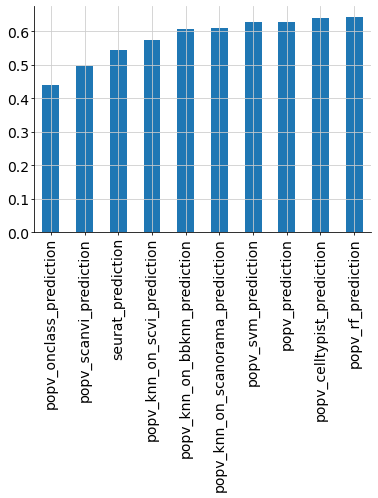

In [12]:
f1_df.sort_values(by='macro')['macro'].plot.bar()

<AxesSubplot:>

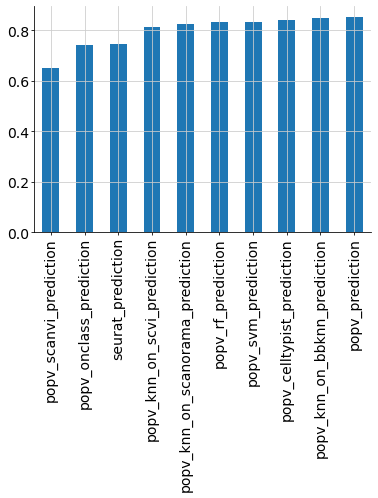

In [13]:
f1_df.sort_values(by='weighted')['weighted'].plot.bar()

<AxesSubplot:>

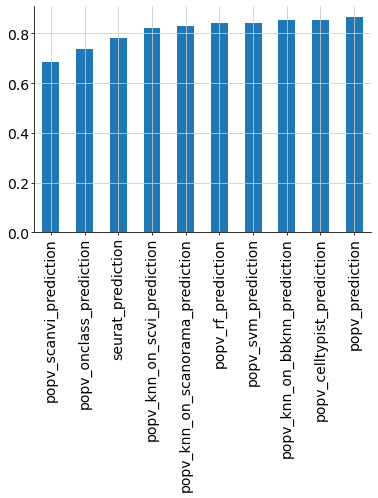

In [14]:
f1_df.sort_values(by='micro')['micro'].plot.bar()

## Best F1 score per celltype

In [15]:
pred_keys

['popv_celltypist_prediction',
 'popv_knn_on_bbknn_prediction',
 'popv_knn_on_scanorama_prediction',
 'popv_knn_on_scvi_prediction',
 'popv_onclass_prediction',
 'popv_rf_prediction',
 'popv_scanvi_prediction',
 'popv_svm_prediction',
 'seurat_prediction',
 'popv_prediction']

In [16]:
all_ct = list(np.unique(adata.obs[pred_keys]))

ct_df = pd.DataFrame(index=all_ct)

In [17]:
for key in pred_keys:
    y_pred = list(adata.obs[key].str.lower())
    res = classification_report(y_true, y_pred, output_dict=True)
    tmp={}
    for ct in all_ct:
        if ct in res.keys():
            tmp[ct] = res[ct]['f1-score']
        else:
            tmp[ct] = 0
    ct_df[key] = ct_df.index.map(tmp)    

/home/cane/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cane/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cane/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cane/miniconda3/lib/python3.8/site-p

In [18]:
# ct_df = ct_df[pred_keys+ ['ontology_vote_onclass_wo_bbknn_svm']] 
ct_df = ct_df[pred_keys] 

In [19]:
mins = ct_df[pred_keys].min(axis=1)
maxs = ct_df[pred_keys].max(axis=1)

In [20]:
ct_df['range'] = maxs-mins
ct_df['std'] = ct_df[pred_keys].std(axis=1)

In [21]:
ct_df['best method'] = ct_df[pred_keys].idxmax(axis=1)

In [22]:
idx = []
for k in ct_df.index:
    if k not in np.unique(adata.obs['cell_ontology_class']):
        idx.append(k+'*')
    else:
        idx.append(k)
ct_df.index=idx

In [23]:
ct_df.sort_values(by='std', ascending=False)

,popv_celltypist_prediction,popv_knn_on_bbknn_prediction,popv_knn_on_scanorama_prediction,popv_knn_on_scvi_prediction,popv_onclass_prediction,popv_rf_prediction,popv_scanvi_prediction,popv_svm_prediction,seurat_prediction,popv_prediction,range,std,best method
serous cell of epithelium of bronchus,0.000000,0.166667,0.000000,0.222222,0.080000,0.863636,0.920000,0.933333,0.979592,0.344828,0.979592,0.420474,seurat_prediction
lung ciliated cell,0.992908,0.993411,0.996439,0.990626,0.026933,0.992138,0.992397,0.995174,0.995682,0.995682,0.969507,0.305765,popv_knn_on_scanorama_prediction
neutrophil,0.990099,0.843478,0.882629,0.896552,0.970588,0.966184,0.730594,0.980198,0.000000,0.975610,0.990099,0.300639,popv_celltypist_prediction
alveolar capillary type 2 endothelial cell,0.902686,0.938918,0.727808,0.914761,0.535897,0.898139,0.895059,0.909717,0.000000,0.920909,0.938918,0.296389,popv_knn_on_bbknn_prediction
capillary endothelial cell,0.902052,0.936300,0.742695,0.898457,0.934018,0.903335,0.000000,0.895999,0.765568,0.925466,0.936300,0.285935,popv_knn_on_bbknn_prediction
endothelial cell of artery,0.895970,0.879641,0.833333,0.426688,0.787552,0.829468,0.064249,0.764085,0.710861,0.886618,0.831721,0.264616,popv_celltypist_prediction
mesothelial cell,0.746269,0.263158,0.852459,0.714286,0.058824,0.692308,0.675000,0.692308,0.753623,0.827586,0.793635,0.257117,popv_knn_on_scanorama_prediction
bronchial smooth muscle cell,0.844528,0.816176,0.754987,0.776992,0.106621,0.783784,0.766126,0.790005,0.849353,0.835085,0.742732,0.222363,seurat_prediction
vascular associated smooth muscle cell,0.685348,0.634894,0.645378,0.478947,0.616888,0.550274,0.000000,0.627852,0.621097,0.660915,0.685348,0.202763,popv_celltypist_prediction
pulmonary ionocyte,0.333333,0.584615,0.370370,0.380952,0.734694,0.884615,0.359375,0.473118,0.347107,0.381818,0.551282,0.189887,popv_rf_prediction
